# Step 3: Test, Train, Split, OneHotEncode, Model Function, GridSearch.

## Preprocessing

In [217]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import dates as mpl_dates
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import tree

SyntaxError: invalid syntax (<ipython-input-217-9c71e5754f54>, line 25)

In [174]:
df = pd.read_csv('data/cleaned_data')

In [175]:
df

,date,officer_id,officer_age,officer_race,officer_gender,officer_squad,subject_id,subject_age,subject_race,subject_gender,stop_resolution,weapon_type,initial_call_type,call_type,arrest,frisk,precinct,sector,beat
0,2015-10-16,7500,31,Black or African American,M,SOUTH PCT 1ST W - ROBERT,-1,NaN,Asian,Male,Arrest,None,NaN,NaN,0,0,South,O,O2
1,2015-04-03,6973,38,White,M,NaN,-1,NaN,Black or African American,Male,Field Contact,None,NaN,NaN,0,0,NaN,NaN,NaN
2,2015-04-05,7402,42,White,M,NaN,-1,NaN,Black or African American,Male,Field Contact,None,NaN,NaN,0,0,NaN,NaN,NaN
3,2015-05-20,7591,30,Hispanic or Latino,M,WEST PCT 3RD W - MARY,-1,NaN,Other,Female,Field Contact,None,NaN,NaN,0,0,NaN,NaN,NaN
4,2015-05-20,7591,30,Hispanic or Latino,M,WEST PCT 3RD W - MARY,-1,NaN,White,Male,Field Contact,None,NaN,NaN,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46153,2019-07-17,8633,31,Black or African American,M,TRAINING - FIELD TRAINING SQUAD,25974371966,56 and Above,Black or African American,Male,Arrest,NaN,SHOPLIFT - THEFT,911,1,0,East,E,E2
46154,2019-09-22,8616,33,White,M,WEST PCT 3RD W - KING,25974371966,56 and Above,Black or African American,Male,Offense Report,NaN,BURG - COMM BURGLARY (INCLUDES SCHOOLS),ALARM CALL (NOT POLICE ALARM),0,0,NaN,NaN,NaN
46155,2019-11-08,7769,50,White,M,WEST PCT 1ST W - KING/QUEEN,25974371966,56 and Above,Black or African American,Male,Offense Report,NaN,PURSE SNATCH - ROBBERY,ONVIEW,0,0,West,K,K3
46156,2020-12-26,6799,44,Hispanic or Latino,M,WEST PCT 2ND W - SPECIAL BEATS,25974371966,56 and Above,Black or African American,Male,Field Contact,NaN,SHOPLIFT - THEFT,911,0,0,West,K,K1


In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46158 entries, 0 to 46157
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               46158 non-null  object
 1   officer_id         46158 non-null  int64 
 2   officer_age        46158 non-null  int64 
 3   officer_race       46158 non-null  object
 4   officer_gender     46158 non-null  object
 5   officer_squad      45613 non-null  object
 6   subject_id         46158 non-null  int64 
 7   subject_age        45114 non-null  object
 8   subject_race       46158 non-null  object
 9   subject_gender     46158 non-null  object
 10  stop_resolution    46158 non-null  object
 11  weapon_type        34275 non-null  object
 12  initial_call_type  33482 non-null  object
 13  call_type          33482 non-null  object
 14  arrest             46158 non-null  int64 
 15  frisk              46158 non-null  int64 
 16  precinct           36700 non-null  objec

### Splitting Data Set into X and Y

In [177]:
#isolate columns wanted to compare with frisk
frisk_columns = ['officer_age', 'officer_race', 'officer_gender', 'subject_race', 'subject_gender']

#Establish X and y
y = df['frisk']
X = df[frisk_columns] 

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Remove 'object'-type features from X
cont_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]

# Remove "object"-type features from X_train and X_test
X_train_cont = X_train.loc[:, cont_features]
X_test_cont = X_test.loc[:, cont_features]

In [178]:
print(y.shape)
print(X.shape)

(46158,)
(46158, 5)


### Imputing, Scaling, Encoding 

In [179]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Impute missing values with median using SimpleImputer
impute = SimpleImputer(strategy='median')
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont)

In [180]:
#normalize our data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Scale the train and test data
ss = StandardScaler()
X_train_imputed_scaled = ss.fit_transform(X_train_imputed)
X_test_imputed_scaled = ss.transform(X_test_imputed)

In [181]:
# Create X_cat which contains only the categorical variables
features_cat = [col for col in X.columns if X[col].dtype in [np.object]]
X_train_cat = X_train.loc[:, features_cat]
X_test_cat = X_test.loc[:, features_cat]

# Fill missing values with the string 'missing'
X_train_cat.fillna(value='missing', inplace=True)
X_test_cat.fillna(value='missing', inplace=True)

In [182]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform training and test sets
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame 
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [183]:
#combining all the X_train categorial and continuous data
X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

## Running our X_train, y_train through Machine Learning Function

In [184]:
#Create a function within many Machine Learning Models for train data

def models(X_train_all, y_train):
    
    #Using Logistic Regression Algorithm to the Training Set
    log = LogisticRegression(random_state = 0, max_iter = 50000)
    log.fit(X_train_all, y_train)
    
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_train_all, y_train)
    

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_train_all, y_train)
    
    #Using SVC method of svm class to use Kernel SVM Algorithm
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_train_all, y_train)
    
    
    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    gauss = GaussianNB()
    gauss.fit(X_train_all, y_train)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train_all, y_train)
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train_all, y_train)
    
    print('[0]Logistic Regression Training Accuracy:', log.score(X_train_all, y_train))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train_all, y_train))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train_all, y_train))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train_all, y_train))
    print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train_all, y_train))
    print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train_all, y_train))
    print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train_all, y_train))
    
    return

In [185]:
models(X_train_all, y_train)

[0]Logistic Regression Training Accuracy: 0.7711910307100688
[1]K Nearest Neighbor Training Accuracy: 0.7270216107891458
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.7711910307100688
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.7711910307100688
[4]Gaussian Naive Bayes Training Accuracy: 0.6615934571846396
[5]Decision Tree Classifier Training Accuracy: 0.7826463738287386
[6]Random Forest Classifier Training Accuracy: 0.781563126252505


## Running our X_test, y_test through Machine Learning Function

In [186]:
#test data
def other_models(X_test_all, y_test):
    
    #Using Logistic Regression Algorithm to the Training Set
    log = LogisticRegression(random_state = 0, max_iter = 50000)
    log.fit(X_test_all, y_test)
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_test_all, y_test)

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_test_all, y_test)
    
    #Using SVC method of svm class to use Kernel SVM Algorithm
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_test_all, y_test)
    
    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    gauss = GaussianNB()
    gauss.fit(X_test_all, y_test)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_test = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree_test.fit(X_test_all, y_test)
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_test_all, y_test)
    
    print('[0]Logistic Regression Training Accuracy - X_test, y_test:', log.score(X_test_all, y_test))
    print('[1]K Nearest Neighbor Training Accuracy - X_test, y_test:', knn.score(X_test_all, y_test))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test:', svc_lin.score(X_test_all, y_test))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy - X_test, y_test:', svc_rbf.score(X_test_all, y_test))
    print('[4]Gaussian Naive Bayes Training Accuracy - X_test, y_test:', gauss.score(X_test_all, y_test))
    print('[5]Decision Tree Classifier Training Accuracy - X_test, y_test:', tree_test.score(X_test_all, y_test))
    print('[6]Random Forest Classifier Training Accuracy - X_test, y_test:', forest.score(X_test_all, y_test))
    
    return

In [187]:
other_models(X_test_all, y_test)

[0]Logistic Regression Training Accuracy - X_test, y_test: 0.7717720970537262
[1]K Nearest Neighbor Training Accuracy - X_test, y_test: 0.7644064124783362
[2]Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test: 0.7717720970537262
[3]Support Vector Machine (RBF Classifier) Training Accuracy - X_test, y_test: 0.7717720970537262
[4]Gaussian Naive Bayes Training Accuracy - X_test, y_test: 0.7266031195840554
[5]Decision Tree Classifier Training Accuracy - X_test, y_test: 0.8029679376083189
[6]Random Forest Classifier Training Accuracy - X_test, y_test: 0.7991767764298093


Based on the modeling of train and test data, our best models are Decision Tree and Random Forest Classifier.

### Confusion Matrix and Classification Report for Decision Tree

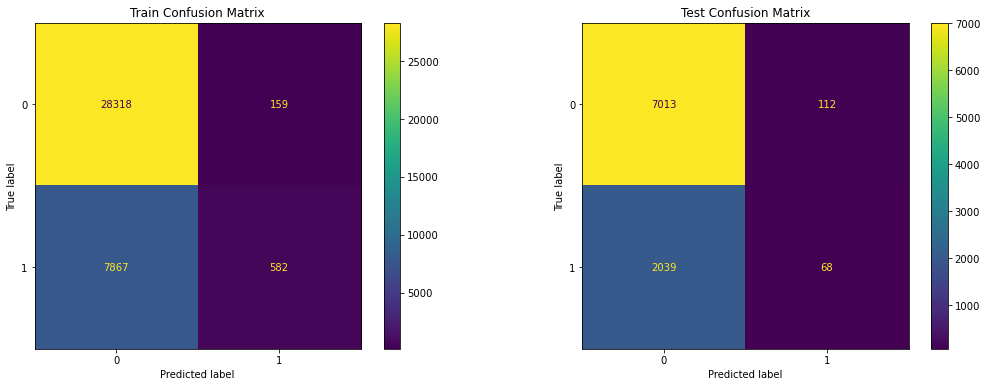

In [188]:
#start decision tree confusion matrix

#instantiation
tree_matrix = DecisionTreeClassifier()

#fitting
tree_matrix.fit(X_train_all, y_train)

#predictions
y_hat_train_ = tree_matrix.predict(X_train_all)
y_hat_test = tree_matrix.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(tree_matrix, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(tree_matrix, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Train Confusion Matrix')
ax1.title.set_text('Test Confusion Matrix')

In [189]:
print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.78      0.99      0.88     28477
           1       0.79      0.07      0.13      8449

    accuracy                           0.78     36926
   macro avg       0.78      0.53      0.50     36926
weighted avg       0.78      0.78      0.70     36926

              precision    recall  f1-score   support

           0       0.77      0.98      0.87      7125
           1       0.38      0.03      0.06      2107

    accuracy                           0.77      9232
   macro avg       0.58      0.51      0.46      9232
weighted avg       0.68      0.77      0.68      9232



In [190]:
#figure out what features are important by level
tree_matrix.feature_importances_
fi = sorted(list(zip(tree_matrix.feature_importances_, X_train.columns)))
fi = pd.DataFrame(fi, columns=['impt', 'name'], )
fi

,impt,name
0,0.012975,officer_race
1,0.023209,subject_gender
2,0.029911,officer_gender
3,0.031218,subject_race
4,0.411719,officer_age


### Confusion Matrix and Classification Report for Random Forest

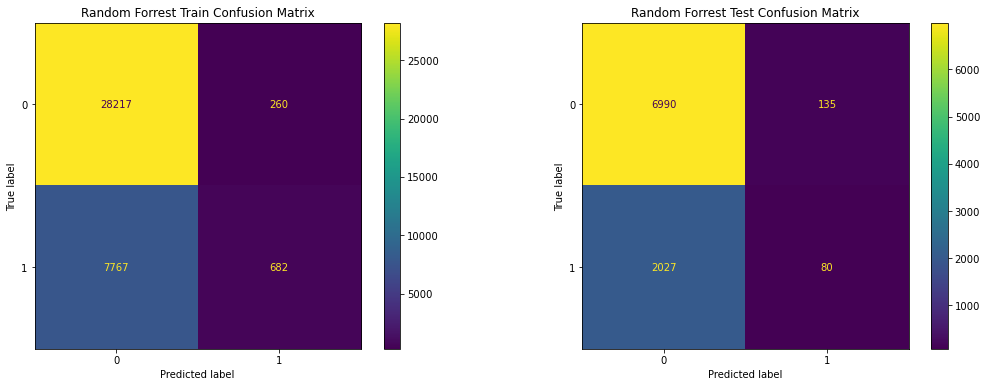

In [191]:
#start decision tree confusion matrix

#instantiation
random_forrest = RandomForestClassifier()

#fitting
random_forrest.fit(X_train_all, y_train)

#predictions
y_forrest_hat_train = random_forrest.predict(X_train_all)
y_forrest_hat_test = random_forrest.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(random_forrest, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(random_forrest, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Random Forrest Train Confusion Matrix')
ax1.title.set_text('Random Forrest Test Confusion Matrix')

In [192]:
#run classification model for Random Forrest
print(classification_report(y_train, y_forrest_hat_train))
print(classification_report(y_test, y_forrest_hat_test))

              precision    recall  f1-score   support

           0       0.78      0.99      0.88     28477
           1       0.72      0.08      0.15      8449

    accuracy                           0.78     36926
   macro avg       0.75      0.54      0.51     36926
weighted avg       0.77      0.78      0.71     36926

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      7125
           1       0.37      0.04      0.07      2107

    accuracy                           0.77      9232
   macro avg       0.57      0.51      0.47      9232
weighted avg       0.68      0.77      0.68      9232



### GridSearch for Decision Tree

In [193]:
#gridsearch on decision tree

#copy X and y from above
y_cv = y
X_cv = X_train_all

#scale
std_slc = StandardScaler()

#using PCA object to make dataset more condense? Found on: https://www.projectpro.io/recipes/optimize-hyper-parameters-of-decisiontree-model-using-grid-search-in-python
pca = decomposition.PCA()

#set decision tree again
dec_tree = tree.DecisionTreeClassifier()

#Create a pipeline of three steps
## Standardize data, transform with PCA, then train decision tree classifier on data
pipe = Pipeline(steps=[('c', std_slc),
                        ('pca', pca),
                        ('dec_tree', dec_tree)])

n_components = list(range(1,X.shape[1]+1,1))

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]

#create parameter space
parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)
    
#establishing classifier
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train_post, y_train_post)

#print statements

print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])


Best Criterion: gini
Best max_depth: 2
Best Number Of Components: 1

DecisionTreeClassifier(max_depth=2)


#### Running the function with GridSearch Recommendations

In [207]:
#test data
def edited_test_models(X_test_all, y_test):

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_grid = DecisionTreeClassifier(criterion = 'gini', random_state = 0, max_depth=2)
    tree_grid.fit(X_test_all, y_test)
    
    print('Decision Tree Classifier Training Accuracy - Test:', tree_grid.score(X_test_all, y_test))
    
    return

In [209]:
edited_test_models(X_test_all, y_test)

Decision Tree Classifier Training Accuracy - Test: 0.7717720970537262


In [212]:
def edited_train_models(X_train_all, y_train):

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree_train_grid = DecisionTreeClassifier(criterion = 'gini', random_state = 0, max_depth=2)
    tree_train_grid.fit(X_train_all, y_train)
    
    print('Decision Tree Classifier Training Accuracy - Train:', tree_train_grid.score(X_test_all, y_test))
    
    return

In [213]:
edited_train_models(X_train_all, y_train)

Decision Tree Classifier Training Accuracy - Train: 0.7717720970537262


## SMOTE

In [216]:
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

ModuleNotFoundError: No module named 'imblearn'